# EMERGE: Constraining observation timescales of merging galaxies
##### About:
This notebook is intended to provide the scripts necessary to reproduce the key results shown [here](https://ui.adsabs.harvard.edu/abs/2020arXiv200102687O/abstract). I omit plots that include data and results of other works.

##### Data:
The data necessary to reproduce these results can be found [here](http://www.usm.uni-muenchen.de/emerge/data/galtrees/hdf5/). This data is produced using the code [EMERGE](http://www.usm.uni-muenchen.de/emerge/)

##### Code:
To run this notebook you will also need to install my personal library of analysis tools [galaxybox](https://github.com/jaoleary/galaxybox). If there are questions regarding the usage of these tools please consult that repository directly...or contact me.

##### Discalimer:
This notebook relies on publicly available data and codes, I cannot gurantee that updates to either of this won't result in a change to the results shown in this notebook or the associated paper. If for some reason you are unable to run this notebook or if you find some error **please** contact me.

# RUN THESE CELLS FIRST

## IMPORT LIBRARIES

In [54]:
from galaxybox_dev import sim_managers as gb
from galaxybox_dev.plot.emerge_plot import plot_stats_clustering

# plotting
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
from matplotlib import container
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#astropy
from astropy import cosmology as apcos
from astropy import constants as apconst
import astropy.units as apunits

#halotools
from halotools.mock_observables import wp

# scipy
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic
import scipy.interpolate as interpolate
import scipy.integrate as integrate
from scipy.spatial import ckdtree

# other
import os
import pandas as pd
import numpy as np
from multiprocessing import Pool
from jupyterthemes import jtplot # This is not a necessary library. But im a sucker for dark themes
from tqdm.auto import tqdm
import h5py
import warnings
warnings.filterwarnings("ignore")

## PLOTTING DEFAULTS

In [2]:
jtplot.reset()
plt.rcParams.update({'axes.linewidth' : 2,
                     'xtick.labelsize' : 16,
                     'xtick.major.width' : 2,
                     'xtick.major.size'  : 6,
                     'xtick.minor.width'  : 1,
                     'xtick.minor.size'  : 3,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.labelsize' : 16,
                     'ytick.major.width' : 2,
                     'ytick.major.size'  : 6,
                     'ytick.minor.width'  : 1,
                     'ytick.minor.size'  : 3,
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'font.family':'serif',
                     'mathtext.fontset': 'cm'})

## IMPORT DATA

In [3]:
P200 = gb.Universe(param_path = '../../Programs/emerge-dev/parameterfiles/P100.param', sim_type = 'emerge', include=['trees', 'survey','statistics'])
P200.galaxy.sort_index() # sort the galaxy trees by ID.
P200.add_figdir(P200.out_dir+'/obs_timescale_figures/') # this is optional, just make a directory to save all of the figures to.

Loading statistics:
/home/joleary/Programs/emerge-dev/output/P100/statistics.h5


In [4]:
# construct some new lightcone catalogs
#P200.galaxy.survey.new_observation(group='GOODS-S', name='wide', m=8, n=5, min_z=0.5, max_z=3, min_mstar=9, fuzzy_bounds=True, randomize=True, seed=42)
#P200.galaxy.survey.new_observation(group='GOODS-N', name='wide', m=8, n=5, min_z=0.5, max_z=3, min_mstar=9, fuzzy_bounds=True, randomize=True, seed=24)
#P200.galaxy.survey.save()

# load previously saved lightcone catalogs
P200.galaxy.survey.load_group(group='GOODS-S', link_trees=True)
P200.galaxy.survey.load_group(group='GOODS-N', link_trees=True)

## DEFINE FUNCTIONS

In [85]:
# a wrapper function to parallelize the mergeing_time method
def parallel_merging_time(ipair):
    igal_1 = ipair[0]
    igal_2 = ipair[1]
    return P200.galaxy.merging_time(igal_1, igal_2)

def get_pairs(observation, num_procs=1):
    # a pair catalog for each slice of the cone
    pairs = [None]*(len(observation.redshift_bins)-1)
    
    #loop over each cone slice
    for i in tqdm(range(len(pairs))):
        pairs[i] = pd.DataFrame(columns=['slice', 'dok_main', 'dok_minor','cone_id_main', 'cone_id_minor', 'tree_id_main', 'tree_id_minor', 'radius', 'dz', 'MR', 'tdf'])
        
        pair_dok = np.array(observation.distmat[i].nonzero()).T
        galaxies = observation.list(slice=i)
        # get the properties for each pair
        G1_prop = galaxies.iloc[pair_dok[:,0]]
        G2_prop = galaxies.iloc[pair_dok[:,1]]

        MR = (G1_prop['Stellar_mass'].values-G2_prop['Stellar_mass'].values)
        MR_mask = (MR>=0) & (MR<1)
        MR = MR[MR_mask]
        MR = 10**MR
        pairs[i]['MR'] = MR

        pair_dok = pair_dok[MR_mask]
        pairs[i][['dok_main','dok_minor']] = pair_dok

        G1_prop = G1_prop[MR_mask]
        G2_prop = G2_prop[MR_mask]

        dz = np.abs(G1_prop['Redshift_obs'].values - G2_prop['Redshift_obs'].values)
        pairs[i]['dz'] = dz

        G1_index = G1_prop.index.values
        G2_index = G2_prop.index.values
        pairs[i][['cone_id_main', 'cone_id_minor']] = np.array([G1_index, G2_index]).T

        G1_index = G1_prop.Tree_ID.values
        G2_index = G2_prop.Tree_ID.values
        pairs[i][['tree_id_main', 'tree_id_minor']] = np.array([G1_index, G2_index]).T
        pair_id = [(G1_index[k], G2_index[k]) for k in range(len(G1_index))]
        
        pairs[i]['radius'] = np.zeros(len(pairs[i]['dok_main']))
        for j in range(len(pairs[i]['dok_main'])):
            dok_1 = pairs[i].iloc[j]['dok_main']
            dok_2 = pairs[i].iloc[j]['dok_minor']
            pairs[i].iloc[j]['radius'] = observation.distmat[i][(dok_1, dok_2)]

        with Pool(processes=num_procs) as pool:
            # if you are in desperate need of another loading bar use imap
            #pairs[i]['tdf'] = np.array(list(tqdm(pool.imap(parallel_merging_time, pair_id),total=len(pair_id))))
            pairs[i]['tdf'] = np.array(list(pool.map(parallel_merging_time, pair_id)))
        
    return pairs

# DARK MATTER SIMULATIONS AND EMERGE

## High redshift clustering

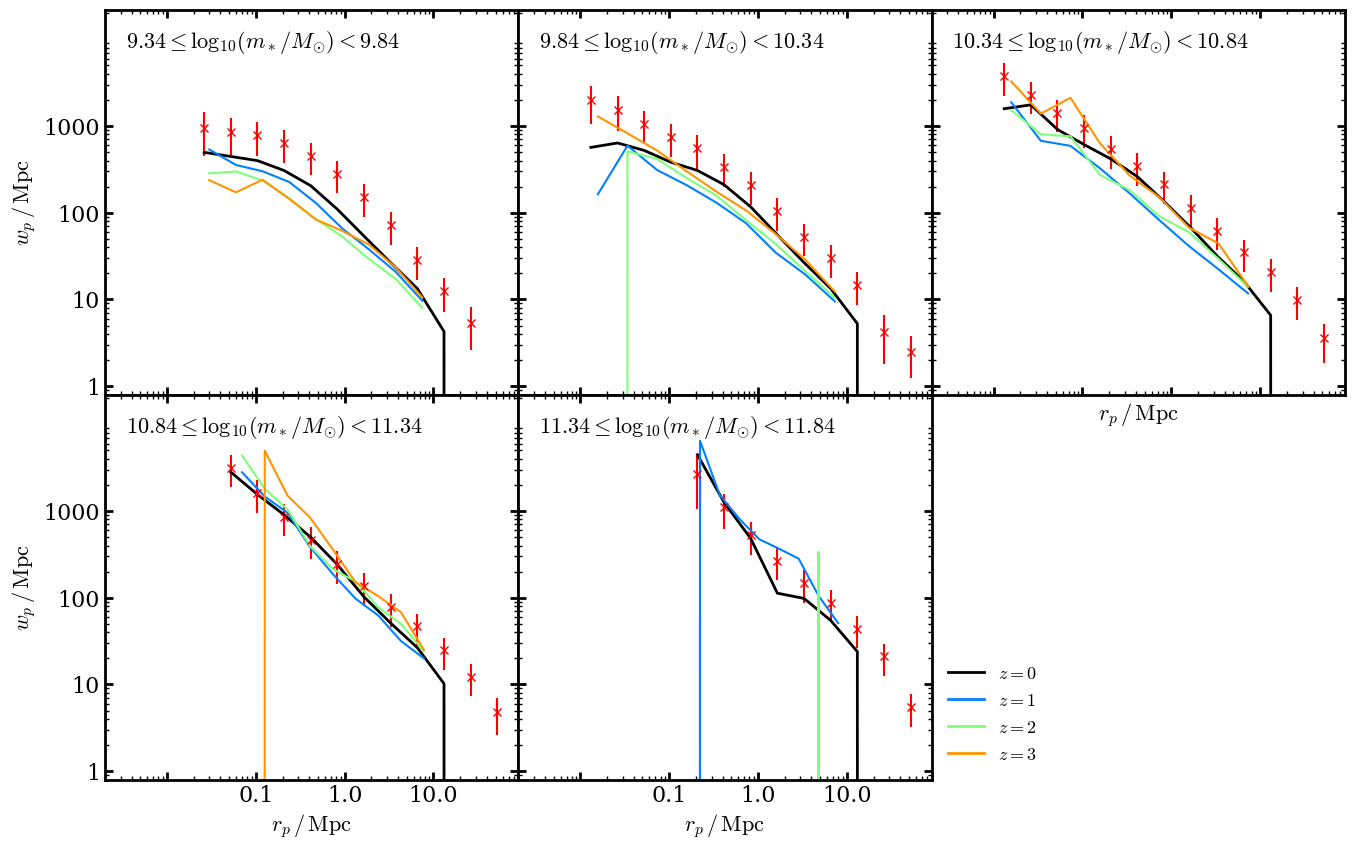

In [100]:
handles = []
ax = plot_stats_clustering(P200.statistics.Clustering, observations=True, color='k', lw=2)
handles += [Line2D([0], [0], color='k', lw=2, ls = '-', label='$z=0$')]

mass_bins = np.array([9.34, 9.84, 10.34, 10.84, 11.34, 11.84])
pi_max = 10/P200.cosmology.h
rp_range = [(0.02, 30),
            (0.01, 60),
            (0.01, 60),
            (0.05, 60),
            (0.1, 60)]
redshifts = [1, 2, 3]
color = [plt.cm.jet((1)/float(4)), plt.cm.jet((2)/float(4)), plt.cm.jet((3)/float(4))]
for j, z in enumerate(redshifts):
    handles += [Line2D([0], [0], color=color[j], lw=2, ls = '-', label='$z={}$'.format(z))]
    for i, axi in enumerate(ax.reshape(-1)[:-1]):
        rmin = np.log10(rp_range[i][0])
        rmax = np.log10(rp_range[i][1])
        rp_bins = np.logspace(rmin,1,10)
        rpc = (rp_bins[:-1]+rp_bins[1:])/2
        min_mass = mass_bins[i]
        max_mass = mass_bins[i+1]
        coords = P200.galaxy.list(min_mstar=min_mass, max_mstar=max_mass,z=z)[['X_pos', 'Y_pos', 'Z_pos']].values
        if len(coords) > 0:
            xi = wp(coords, rp_bins, pi_max, period=P200.BoxSize/P200.cosmology.h)
            axi.plot(rpc,xi, color=color[j])

ax[-1,-1].axis('off')
ax[0,2].set_xlabel('$r_p \, / \, \mathrm{Mpc}$', size=16)
ax[0,0].texts[0].remove()
ax[0,0].annotate('$9.34 \leq \log_{10}(m_*/M_{\odot}) < 9.84$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')
ax[0,1].texts[0].remove()
ax[0,1].annotate('$9.84 \leq \log_{10}(m_*/M_{\odot}) < 10.34$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')
ax[0,2].texts[0].remove()
ax[0,2].annotate('$10.34 \leq \log_{10}(m_*/M_{\odot}) < 10.84$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')
ax[1,0].texts[0].remove()
ax[1,0].annotate('$10.84 \leq \log_{10}(m_*/M_{\odot}) < 11.34$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')
ax[1,1].texts[0].remove()
ax[1,1].annotate('$11.34 \leq \log_{10}(m_*/M_{\odot}) < 11.84$', xy=(0.05, 1-0.05), xycoords='axes fraction', size=16, ha='left', va='top')

ax[-1,-1].legend(handles=handles, frameon=False, loc='lower left', prop={'size':13})


plt.show()

# Compute pair fractions

In [ ]:
# first bin then setup the distance matrix for each observation
observations = [('GOODS-S', 'wide'),
                ('GOODS-N', 'wide')]
for i, obs in enumerate(observations):
    group, name = obs
    redshift_bins = 5
    observation = P200.galaxy.survey.obs(group=group, name=name)
    observation.set_cone_slice(bins=redshift_bins)
    observation.set_distance_matrix(max_distance=0.1, comoving=False)  
    observation.pairs = get_pairs(observation, num_procs=8)
    

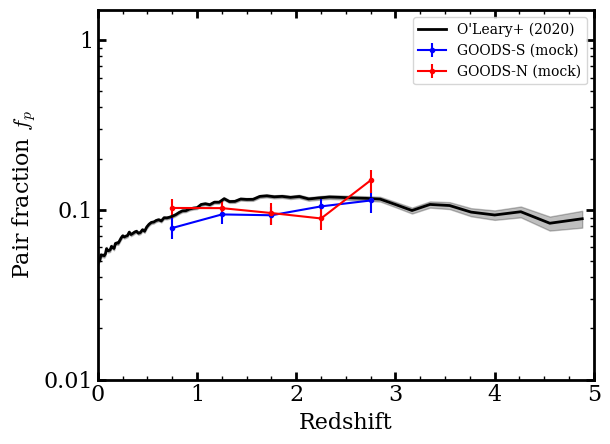

In [62]:
min_mstar, max_mstar = 10.3, np.inf
r_min, r_max = 0.005, 0.05
min_MR, max_MR = 1, 4
dv_max = 500

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xlim(0,5)
ax.set_ylim(0.01, 1.5)
ax.set_ylabel('Pair fraction $f_{p}$', size=16)
ax.set_xlabel('Redshift', size=16)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 4.5+75, 0.25)))

color = ['b','r']

pairs = pd.read_hdf('./pair_counts.h5', key='P4')

z=pairs['redshift']
Np = (pairs['rp:50']-pairs['rp:5'])
Ng = pairs['N_gal']
fp = Np/Ng
err = fp/np.sqrt(Np)
ax.plot(z, fp,color='k', lw=2,label='O\'Leary+ (2020)')
ax.fill_between(z,fp+err,fp-err,alpha=0.25, color='k')

for i, obs in enumerate(observations):
    group, name = obs
    observation = P200.galaxy.survey.obs(group=group, name=name)
    bins = observation.redshift_bins
    z = (bins[:-1] + bins[1:])/2
    
    pairs = observation.pairs
    Np = np.zeros(len(pairs))
    Ng = np.zeros(len(pairs))
    for j in range(len(Np)):
        mstar = observation.list(index = pairs[j]['cone_id'][:,0])['Stellar_mass'].values
        mstar_mask = (mstar >= min_mstar) & (mstar < max_mstar)
        redshift = observation.list(index = pairs[j]['cone_id'][:,0])['Redshift'].values 
        dz_mask = (pairs[j]['dz'] <= dv_max*(1+redshift)/apconst.c.to('km/s').value)
        radius_mask = (pairs[j]['radius'] >= r_min) & (pairs[j]['radius'] < r_max)
        MR_mask = (pairs[j]['MR'] >= 1) & (pairs[j]['MR'] < 4)
        Np[j] = (mstar_mask & dz_mask & radius_mask & MR_mask).sum()
        Ng[j] = len(observation.list(slice=[j], min_mstar=min_mstar, max_mstar=max_mstar)) 

    fp = Np/Ng
    err = fp/np.sqrt(Np)
    ax.errorbar(z, fp, yerr=err, marker='.', color=color[i],label=group+' (mock)')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

plt.legend()
plt.savefig(P200.fig_dir+'/pair_fraction.pdf',bbox_inches='tight')
plt.show()

## Compute correction factor

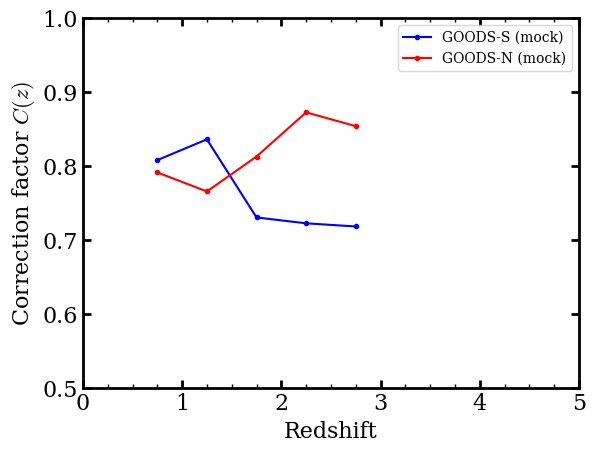

In [11]:
fig, ax = plt.subplots()

ax.set_xlim(0,5)
ax.set_ylim(0.5, 1.)
ax.set_ylabel('Correction factor $C(z)$', size=16)
ax.set_xlabel('Redshift', size=16)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 4.5+75, 0.25)))

for i, obs in enumerate(observations):
    group, name = obs
    bins = P200.galaxy.survey.obs(group=group, name=name).redshift_bins
    z = (bins[:-1] + bins[1:])/2
    pairs = P200.galaxy.survey.obs(group=group, name=name).get_pairs(r_min=0.005, r_max=0.05, min_mstar=10.3)
    C=np.array([None]*len(pairs))
    
    for j, cone_pairs in enumerate(pairs):
        Tree_ID_1 = P200.galaxy.survey.obs(group=group, name=name).list(index=np.array(cone_pairs)[:,0]).Tree_ID.values
        Tree_ID_2 = P200.galaxy.survey.obs(group=group, name=name).list(index=np.array(cone_pairs)[:,1]).Tree_ID.values

        tree_pairs = [(Tree_ID_1[k], Tree_ID_2[k]) for k in range(len(cone_pairs))]

        count = 0
        for p in tree_pairs:
            igal_1 = p[0]
            igal_2 = p[1]
            desc = P200.galaxy.common_descendant(igal_1, igal_2)
            #print(desc)
            if desc > 0:
                count += 1
        C[j] = count/len(cone_pairs)
    ax.plot(z, C, marker='.', color=color[i],label=group+' (mock)')
    
plt.legend()
plt.savefig(P200.fig_dir+'/correction_factor.pdf',bbox_inches='tight')
plt.show()

## Compute observation timescales

# SCRATCH

In [12]:
pairs = P200.galaxy.survey.obs(group=group, name=name).get_pairs(r_min=0.005, r_max=0.05, min_mstar=10.3)

In [13]:
cone_pairs = pairs[0]
Tree_ID_1 = P200.galaxy.survey.obs(group=group, name=name).list(index=np.array(cone_pairs)[:,0]).Tree_ID.values
Tree_ID_2 = P200.galaxy.survey.obs(group=group, name=name).list(index=np.array(cone_pairs)[:,1]).Tree_ID.values
tree_pairs = [(Tree_ID_1[k], Tree_ID_2[k]) for k in range(len(cone_pairs))]

In [16]:
for i, p in enumerate(tree_pairs):
    igal_1 = p[0]
    igal_2 = p[1]
    time = P200.galaxy.merging_time(igal_1, igal_2)
    desc = P200.galaxy.common_descendant(igal_1, igal_2)
    print(i, desc, time)

0 7732816 10.306140899658203
1 7895823 8.55552864074707
2 0 0
3 0 0
4 11779425 9.280662536621094
5 0 0
6 11813853 9.92251205444336
7 0 0
8 11943346 11.901845932006836
9 0 0
10 6012007 8.51541519165039
11 6383623 9.322725296020508
12 6583843 11.219823837280273
13 0 0
14 2428159 8.208784103393555
15 13717202 8.469588279724121
16 3968029 8.0701265335083
17 3968029 9.237396240234375
18 4015066 8.302865982055664
19 6328370 9.128304481506348
20 6372839 7.394207000732422
21 0 0
22 7765866 7.206885814666748
23 7807708 7.708242416381836
24 11443212 8.09262752532959
25 11443212 11.89048957824707
26 11443212 13.357749938964844
27 11805396 7.101747989654541
28 0 0
29 114500 12.042020797729492
30 114500 12.042020797729492
31 180197 7.074894905090332
32 7732816 7.379810810089111
33 7732816 10.306140899658203
34 7732816 10.306140899658203
35 2323975 7.808207988739014
36 9799470 12.983166694641113
37 9891080 9.879632949829102
38 9907979 6.9576640129089355
39 9959546 8.338340759277344
40 9967349 8.0622

In [80]:
P200.galaxy.survey.obs(group=group, name=name).pairs[0]['dok']

array([[ 750,    0],
       [   2,    3],
       [ 868,    6],
       ...,
       [ 353, 2263],
       [ 354, 2263],
       [1683, 2266]], dtype=int32)

In [24]:
igal_1, igal_2 = tree_pairs[34]
print(igal_1, igal_2)

7733002 7733197


In [23]:
inode_1 = P200.galaxy.next_node(igal_1)
inode_2 = P200.galaxy.next_node(igal_1)
print(inode_1, inode_2)

7732856 7732856


2324014 2324014


In [26]:
while inode_1 != inode_2:
    # step forward on the galaxy that is at an earlier epoch
    if scale_1 < scale_2:
        gal_1 = P200.galaxy.next_node(inode_1, id_only=False)
        inode_1 = gal_1.name
        scale_1 = gal_1.Scale

    if scale_2 < scale_1:
        gal_2 = P200.galaxy.next_node(inode_2, id_only=False)
        inode_2 = gal_2.name
        scale_2 = gal_2.Scale
print(inode_1, inode_2)

7732856 7732856


In [23]:
P200.galaxy.tree(7732838)

,Scale,Up_ID,Desc_ID,Main_ID,MMP_ID,Coprog_ID,Leaf_ID,Original_ID,Num_prog,MMP,...,X_pos,Y_pos,Z_pos,X_vel,Y_vel,Z_vel,tdf,Age,Type,Flag
ID,,,,,,,,,,,,,,,,,,,,,
7732838,0.78,0,7732837,7732838,7732839,0,7733390,10687483,2,1,...,94.753662,3.534862,7.090311,80.459999,-199.580002,-246.850006,10.448819,10.448819,0,0
7732839,0.77,0,7732838,7732839,7732840,7733175,7733174,10540690,1,1,...,94.729897,3.578027,7.141469,65.260002,-204.720001,-239.210007,10.288908,10.288908,0,0
7732840,0.76,0,7732839,7732840,7732841,0,7733174,10393471,1,1,...,94.705673,3.626117,7.192729,87.320000,-224.070007,-263.279999,10.128458,10.128458,0,0
7732841,0.75,0,7732840,7732841,7732842,0,7733174,10245193,1,1,...,94.690079,3.674620,7.248164,81.589996,-220.850006,-275.179993,9.967490,9.967490,0,0
7732842,0.74,0,7732841,7732842,7732843,0,7733174,10096153,1,1,...,94.667488,3.727533,7.308863,87.930000,-224.779999,-258.130005,9.806028,9.806028,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7733386,0.24,0,7733385,7733386,7733387,0,7733390,1603956,1,1,...,93.986420,6.485798,12.181611,62.419998,-138.210007,-279.140015,2.026123,2.026123,0,0
7733387,0.23,0,7733386,7733387,7733388,0,7733390,1436775,1,1,...,93.956970,6.570284,12.328816,64.160004,-142.580002,-266.359985,1.901974,1.901974,0,0
7733388,0.22,0,7733387,7733388,7733389,0,7733390,1274105,1,1,...,93.919571,6.637325,12.461422,66.099998,-135.550003,-249.820007,1.780284,1.780284,0,0


In [112]:
igal_1, igal_2 = 7732850, 7733186
merging_time(igal_1, igal_2)

(10.306140899658203, 'F', 7732838.0)

In [114]:
P200.galaxy.list(redshift='all', Desc_ID=7732838)

,Scale,Up_ID,Desc_ID,Main_ID,MMP_ID,Coprog_ID,Leaf_ID,Original_ID,Num_prog,MMP,...,X_pos,Y_pos,Z_pos,X_vel,Y_vel,Z_vel,tdf,Age,Type,Flag
ID,,,,,,,,,,,,,,,,,,,,,
7732839,0.77,0,7732838,7732839,7732840,7733175,7733174,10540690,1,1,...,94.729897,3.578027,7.141469,65.260002,-204.720001,-239.210007,10.288908,10.288908,0,0
7733175,0.77,7732839,7732838,7732839,7733176,0,7733390,18040964,1,0,...,94.742867,3.568967,7.142544,65.260002,-204.720001,-239.210007,10.306141,10.288908,2,1


In [74]:
idx = 3
mb = np.arange(10)

In [102]:
max(1,3)

3

In [91]:
P200.galaxy.trees.keys()

Index(['Scale', 'Up_ID', 'Desc_ID', 'Main_ID', 'MMP_ID', 'Coprog_ID',
       'Leaf_ID', 'Original_ID', 'Num_prog', 'MMP', 'Halo_mass',
       'Halo_growth_rate', 'Halo_mass_peak', 'Scale_peak_mass', 'Stellar_mass',
       'SFR', 'Intra_cluster_mass', 'Stellar_mass_obs', 'SFR_obs',
       'Stellar_mass_root', 'Halo_radius', 'Concentration', 'Halo_spin',
       'X_pos', 'Y_pos', 'Z_pos', 'X_vel', 'Y_vel', 'Z_vel', 'tdf', 'Age',
       'Type', 'Flag'],
      dtype='object')

In [84]:
class MyClass:
    pass

def func(self):
    print("func")

MyClass.myMethod = func

In [87]:
from galaxybox_dev.helper_functions.functions import arg_parser
import inspect

In [90]:
inspect.getfullargspec(P200.galaxy.redshift_at_massfrac)[0]

['self', 'igal', 'frac']

In [19]:
observation.redshift_bins

array([0.5, 1. , 1.5, 2. , 2.5, 3. ])

In [136]:
def parallel_merging_time(ipair):
    igal_1 = ipair[0]
    igal_1 = ipair[1]
    return P200.galaxy.merging_time(igal_1, igal_2)

pairs = [None]*(len(observation.redshift_bins)-1)
i = 0
pairs[i] = {}

pair_dok = np.array(observation.distmat[i].nonzero()).T
galaxies = observation.list(slice=i)
# get the properties for each pair
G1_prop = galaxies.iloc[pair_dok[:,0]]
G2_prop = galaxies.iloc[pair_dok[:,1]]

MR = (G1_prop['Stellar_mass'].values-G2_prop['Stellar_mass'].values)
MR_mask = (MR>=0) & (MR<1)
MR = MR[MR_mask]
MR = 10**MR
pairs[i]['MR'] = MR

pair_dok = pair_dok[MR_mask]
pairs[i]['dok'] = pair_dok

G1_prop = G1_prop[MR_mask]
G2_prop = G2_prop[MR_mask]

dz = np.abs(G1_prop['Redshift_obs'].values - G2_prop['Redshift_obs'].values)
pairs[i]['dz'] = dz

G1_index = G1_prop.index.values
G2_index = G2_prop.index.values
pairs[i]['cone_id'] = np.array([G1_index, G2_index]).T

G1_index = G1_prop.Tree_ID.values
G2_index = G2_prop.Tree_ID.values
pairs[i]['tree_id'] = np.array([G1_index, G2_index]).T
pair_id = [(G1_index[k], G2_index[k]) for k in range(len(G1_index))]

#time = np.zeros(len(pairs[i]['tree_id']))
#for j, tdf in enumerate(tqdm(time)):
#    igal_1 = pairs[i]['tree_id'][j][0]
#    igal_2 = pairs[i]['tree_id'][j][1]
#    tdf = P200.galaxy.merging_time(igal_1, igal_2)
#    time[i] = tdf

#pairs[i]['tdf'] = time

num_procs=8
with Pool(processes=num_procs) as pool:
    pairs[i]['tdf'] = np.array(list(tqdm(pool.imap(parallel_merging_time, pair_id),total=len(pair_id))))
    #pairs[i]['tdf'] = np.array(list(pool.map(parallel_merging_time, pair_id)))





In [143]:
# a wrapper function to parallelize the mergeing_time method
def parallel_merging_time(ipair):
    igal_1 = ipair[0]
    igal_1 = ipair[1]
    return P200.galaxy.merging_time(igal_1, igal_2)

def get_pairs(observation, num_proc=1):
    # a pair catalog for each slice of the cone
    pairs = [None]*(len(observation.redshift_bins)-1)
    
    #loop over each cone slice
    for i in tqdm(range(len(pairs))):
        pairs[i] = {}
        
        pair_dok = np.array(observation.distmat[i].nonzero()).T
        galaxies = observation.list(slice=i)
        # get the properties for each pair
        G1_prop = galaxies.iloc[pair_dok[:,0]]
        G2_prop = galaxies.iloc[pair_dok[:,1]]

        MR = (G1_prop['Stellar_mass'].values-G2_prop['Stellar_mass'].values)
        MR_mask = (MR>=0) & (MR<1)
        MR = MR[MR_mask]
        MR = 10**MR
        pairs[i]['MR'] = MR

        pair_dok = pair_dok[MR_mask]
        pairs[i]['dok'] = pair_dok

        G1_prop = G1_prop[MR_mask]
        G2_prop = G2_prop[MR_mask]

        dz = np.abs(G1_prop['Redshift_obs'].values - G2_prop['Redshift_obs'].values)
        pairs[i]['dz'] = dz

        G1_index = G1_prop.index.values
        G2_index = G2_prop.index.values
        pairs[i]['cone_id'] = np.array([G1_index, G2_index]).T

        G1_index = G1_prop.Tree_ID.values
        G2_index = G2_prop.Tree_ID.values
        pairs[i]['tree_id'] = np.array([G1_index, G2_index]).T
        pair_id = [(G1_index[k], G2_index[k]) for k in range(len(G1_index))]

        num_procs=8
        with Pool(processes=num_procs) as pool:
            # if you are in desperate need of another loading bar use imap
            #pairs[i]['tdf'] = np.array(list(tqdm(pool.imap(parallel_merging_time, pair_id),total=len(pair_id))))
            pairs[i]['tdf'] = np.array(list(pool.map(parallel_merging_time, pair_id)))
        
    return pairs

In [144]:
MR = (G1_prop['Stellar_mass'].values-G2_prop['Stellar_mass'].values)
MR_mask = (MR>=0) & (MR<1)
MR = MR[MR_mask]
MR = 10**MR

In [145]:
pairs = get_pairs(observation)

In [103]:
G1_index = G1_prop.index.values
G2_index = G2_prop.index.values

In [128]:
def parallel_merging_time(ipair):
    igal_1 = ipair[0]
    igal_1 = ipair[1]
    return P200.galaxy.merging_time(igal_1, igal_2)

num_procs=8
with Pool(processes=num_procs) as pool:
    #result = np.array(list(tqdm(pool.imap(parallel_merging_time, pair_id),total=len(pair_id))))
    result = np.array(list(pool.map(parallel_merging_time, pair_id)))


In [123]:
   with Pool(2) as p:
      r = list(tqdm.tqdm(p.imap(_foo, range(30)), total=30))

(6722725, 6826083)

In [151]:
import pickle


file = open('pair.pickle', 'wb')
pickle.dump(pairs, file, protocol=pickle.HIGHEST_PROTOCOL)
file.close()

In [131]:
with open('pair.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [21]:
P200.galaxy.survey.obs(group='GOODS-S', name='wide').pairs[0]['tree_id']

array([[ 6662626,   443803],
       [12015732,   493655],
       [10206647,   493655],
       ...,
       [ 3755815,  3826377],
       [ 2190242,  3837644],
       [ 4044086, 10320327]])

In [160]:
pairs[0]['tdf'].max()

0

In [164]:
P200.galaxy.merging_time(pairs[0]['tree_id'][0,:][0], pairs[0]['tree_id'][0,:][1])

0

In [23]:
P200.cosmology.comoving_distance(0.1)

<Quantity 431.71122538 Mpc>

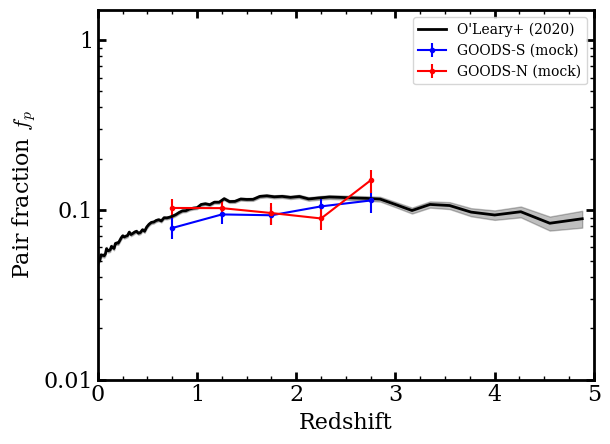

In [61]:
min_mstar, max_mstar = 10.3, np.inf
r_min, r_max = 0.005, 0.05
min_MR, max_MR = 1, 4
dv_max = 500

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xlim(0,5)
ax.set_ylim(0.01, 1.5)
ax.set_ylabel('Pair fraction $f_{p}$', size=16)
ax.set_xlabel('Redshift', size=16)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 4.5+75, 0.25)))

color = ['b','r']

pairs = pd.read_hdf('./pair_counts.h5', key='P4')

z=pairs['redshift']
Np = (pairs['rp:50']-pairs['rp:5'])
Ng = pairs['N_gal']
fp = Np/Ng
err = fp/np.sqrt(Np)
ax.plot(z, fp,color='k', lw=2,label='O\'Leary+ (2020)')
ax.fill_between(z,fp+err,fp-err,alpha=0.25, color='k')

for i, obs in enumerate(observations):
    group, name = obs
    observation = P200.galaxy.survey.obs(group=group, name=name)
    bins = observation.redshift_bins
    z = (bins[:-1] + bins[1:])/2
    
    
    pairs = observation.pairs
    Np = np.zeros(len(pairs))
    Ng = np.zeros(len(pairs))
    for j in range(len(Np)):
        mstar = observation.list(index = pairs[j]['cone_id'][:,0])['Stellar_mass'].values
        mstar_mask = (mstar >= min_mstar) & (mstar < max_mstar)

        redshift = observation.list(index = pairs[j]['cone_id'][:,0])['Redshift'].values 
        dz_mask = (pairs[j]['dz'] <= dv_max*(1+redshift)/apconst.c.to('km/s').value)
        
        radius_mask = (pairs[j]['radius'] >= r_min) & (pairs[j]['radius'] < r_max)
        MR_mask = (pairs[j]['MR'] >= 1) & (pairs[j]['MR'] < 4)
        Np[j] = (mstar_mask & dz_mask & radius_mask & MR_mask).sum()
        Ng[j] = len(observation.list(slice=[j], min_mstar=min_mstar, max_mstar=max_mstar)) 

    fp = Np/Ng
    err = fp/np.sqrt(Np)
    ax.errorbar(z, fp, yerr=err, marker='.', color=color[i],label=group+' (mock)')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

plt.legend()
plt.show()

In [35]:
P200.galaxy.survey.obs(group=group, name=name).pairs[0]['dok']

array([[ 750,    0],
       [   2,    3],
       [ 868,    6],
       ...,
       [ 353, 2263],
       [ 354, 2263],
       [1683, 2266]], dtype=int32)

In [44]:
observation.distmat[0][(750, 0)]

0.07824217426855025

In [37]:
distance = self.distmat[i][(750, 0)]

NameError: name 'self' is not defined

In [47]:
P200.galaxy.survey.obs(group=group, name=name).pairs[0]['cone_id']

array([[ 750,    0],
       [   2,    3],
       [ 868,    6],
       ...,
       [ 353, 2312],
       [ 354, 2312],
       [1683, 2358]])

In [53]:
pairs = observation.pairs
a,b = observation.list(index = pairs[0]['cone_id'][:,0])[['Stellar_mass', 'Redshift']].values

ValueError: too many values to unpack (expected 2)

In [63]:
pairs

[{'MR': array([1.5895386, 2.405686 , 1.994628 , ..., 6.069002 , 1.4504406,
         1.3426301], dtype=float32),
  'dok': array([[ 750,    0],
         [   2,    3],
         [ 868,    6],
         ...,
         [ 353, 2263],
         [ 354, 2263],
         [1683, 2266]], dtype=int32),
  'dz': array([0.25885121, 0.00071646, 0.28470959, ..., 0.39076848, 0.39080375,
         0.10818118]),
  'cone_id': array([[ 750,    0],
         [   2,    3],
         [ 868,    6],
         ...,
         [ 353, 2312],
         [ 354, 2312],
         [1683, 2358]]),
  'tree_id': array([[10056861, 10266125],
         [ 7732850,  7733186],
         [11998855,  7855202],
         ...,
         [ 3781744,  6561247],
         [ 3804534,  6561247],
         [ 6722725,  6826083]]),
  'radius': array([0.07824217, 0.02919663, 0.09887754, ..., 0.05904659, 0.06252714,
         0.09998289]),
  'tdf': array([ 0.       , 10.3061409,  0.       , ...,  0.       ,  0.       ,
          0.       ])},
 {'MR': array([7.9867

In [64]:
pairs[0]

{'MR': array([1.5895386, 2.405686 , 1.994628 , ..., 6.069002 , 1.4504406,
        1.3426301], dtype=float32),
 'dok': array([[ 750,    0],
        [   2,    3],
        [ 868,    6],
        ...,
        [ 353, 2263],
        [ 354, 2263],
        [1683, 2266]], dtype=int32),
 'dz': array([0.25885121, 0.00071646, 0.28470959, ..., 0.39076848, 0.39080375,
        0.10818118]),
 'cone_id': array([[ 750,    0],
        [   2,    3],
        [ 868,    6],
        ...,
        [ 353, 2312],
        [ 354, 2312],
        [1683, 2358]]),
 'tree_id': array([[10056861, 10266125],
        [ 7732850,  7733186],
        [11998855,  7855202],
        ...,
        [ 3781744,  6561247],
        [ 3804534,  6561247],
        [ 6722725,  6826083]]),
 'radius': array([0.07824217, 0.02919663, 0.09887754, ..., 0.05904659, 0.06252714,
        0.09998289]),
 'tdf': array([ 0.       , 10.3061409,  0.       , ...,  0.       ,  0.       ,
         0.       ])}

In [71]:
min_mstar, max_mstar = 10, np.inf
r_min, r_max = 0.005, 0.1
min_MR, max_MR = 1, 10
dv_max = 1000
j=0
mstar = observation.list(index = pairs[j]['cone_id'][:,0])['Stellar_mass'].values
mstar_mask = (mstar >= min_mstar) & (mstar < max_mstar)

redshift = observation.list(index = pairs[j]['cone_id'][:,0])['Redshift'].values
dz_mask = (pairs[j]['dz'] <= dv_max*(1+redshift)/apconst.c.to('km/s').value)

radius_mask = (pairs[j]['radius'] >= r_min) & (pairs[j]['radius'] < r_max)
MR_mask = (pairs[j]['MR'] >= min_MR) & (pairs[j]['MR'] < max_MR)

#merged_mask = pairs[j]['tdf'] > 0

data_mask = (mstar_mask & dz_mask & radius_mask & MR_mask)

mstar = mstar[data_mask]
MR = pairs[j]['MR'][data_mask]
redshift = redshift[data_mask]
radius = pairs[j]['radius'][data_mask]
dz = pairs[j]['dz'][data_mask]
data = np.array([mstar, MR, redshift, radius, dz]).T

df = pd.DataFrame(data, columns=['mass', 'mu', 'z', 'rproj', 'dz'])

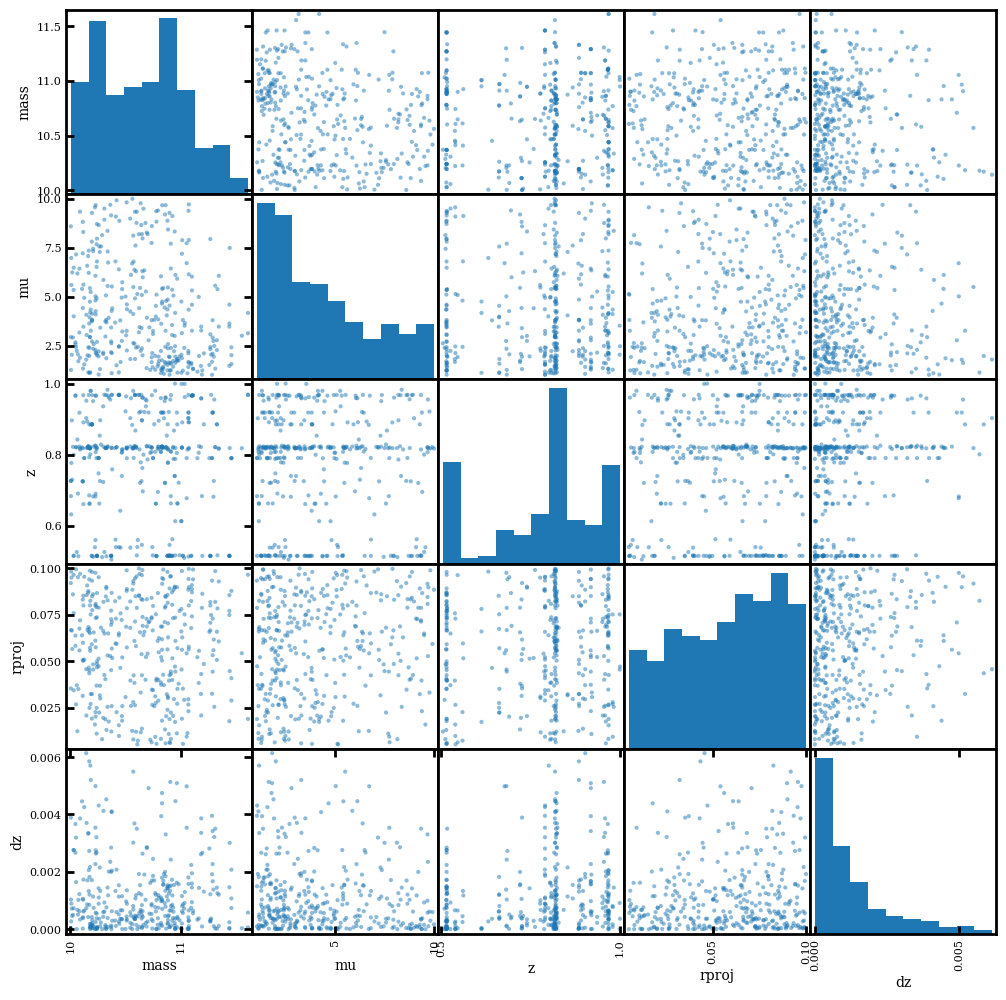

In [78]:
from pandas.plotting import scatter_matrix


scatter_matrix(df, figsize=(12, 12), diagonal='hist')
plt.show()